In [9]:
%matplotlib inline
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from preprocessing import read_data, articles_from_csv_reader, dummy_str_reader, get_word_embeddings
from visualize import visualize, unfold_and_plot
from tools import revert_mapping
import numpy as np
import spacy
import constants
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from IPython.display import Image
from IPython.display import display
from net import Net
from os.path import isdir
from forest import forest_candidates, cut_subgraph

In [2]:
data_dir = '/home/arne/devel/ML/data/'
assert isdir(data_dir), 'data_dir='+data_dir+' is no directory'

dim = 300
edge_count = 60
seq_length = 10

slice_size = 30
max_forest_count = 5

nlp = spacy.load('en')
nlp.pipeline = [nlp.tagger, nlp.parser]

In [3]:
vecs, mapping, human_mapping = get_word_embeddings(nlp.vocab)
data_embedding_maps = {constants.WORD_EMBEDDING: mapping}
data_embedding_maps_human = {constants.WORD_EMBEDDING: human_mapping}
data_vecs = {constants.WORD_EMBEDDING: vecs}

Total time running get_word_embeddings: 8.50456809998 seconds


In [4]:
# create data arrays
seq_data, seq_types, seq_parents, seq_edges = \
    read_data(articles_from_csv_reader, nlp, data_embedding_maps, max_forest_count=max_forest_count, max_sen_length=slice_size,
              args={'max_articles': 1, 'filename': data_dir + 'corpora/documents_utf8_filtered_20pageviews.csv'})

parse 1 articles...
read article: wikipedia-23885690 ...  0 %
Total time running read_data: 0.103231906891 seconds


In [10]:
data_maps_reverse = {}
for key in data_embedding_maps:
    data_maps_reverse[key] = revert_mapping(data_embedding_maps[key])

# take first 50 token and visualize the dependency graph
start = 1
end = 10
sliced_parents = seq_parents[start:end]
cut_subgraph(sliced_parents)
sliced_data = seq_data[start:end]
sliced_types = seq_types[start:end]
sliced_edges = seq_edges[start:end]
visualize('forest.png', (sliced_data, sliced_types, sliced_parents, sliced_edges), data_maps_reverse, nlp.vocab)
Image('forest.png')

KeyError: 159

correct_forrest_ind: 16


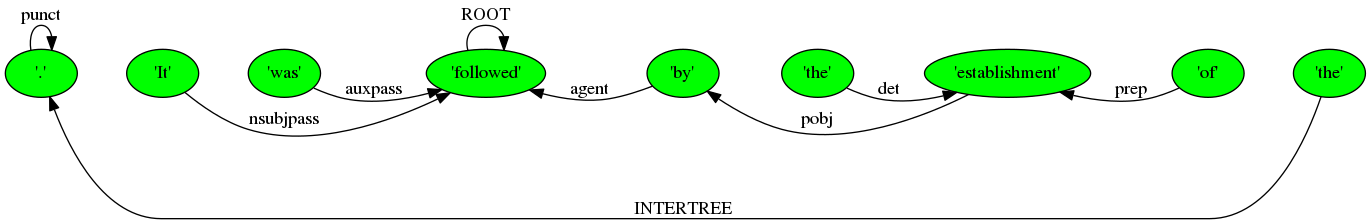

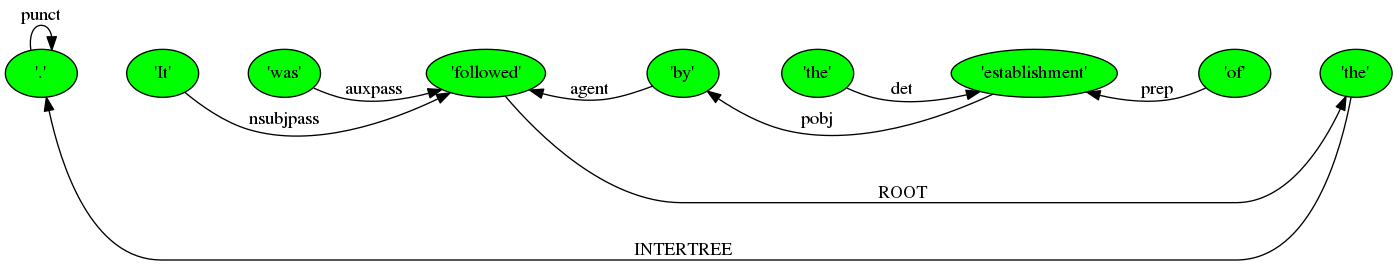

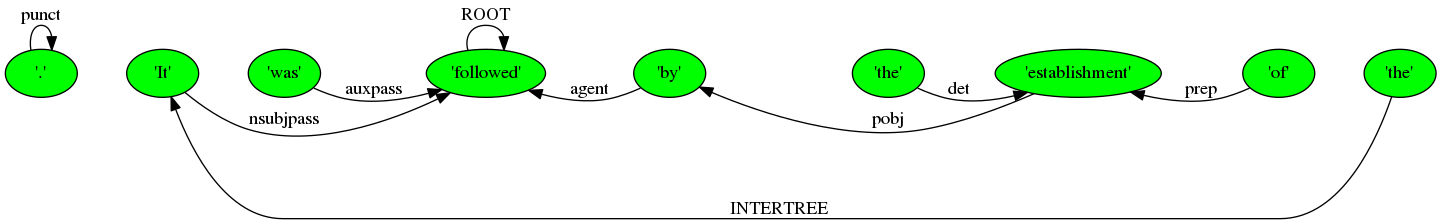

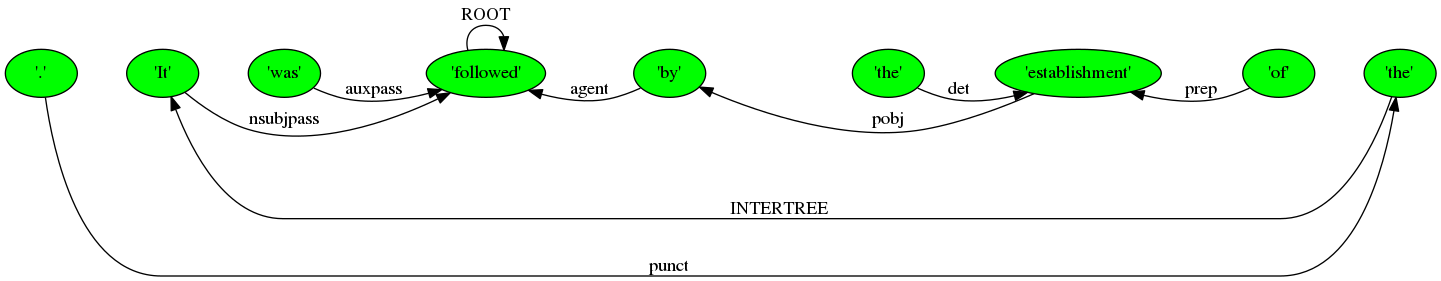

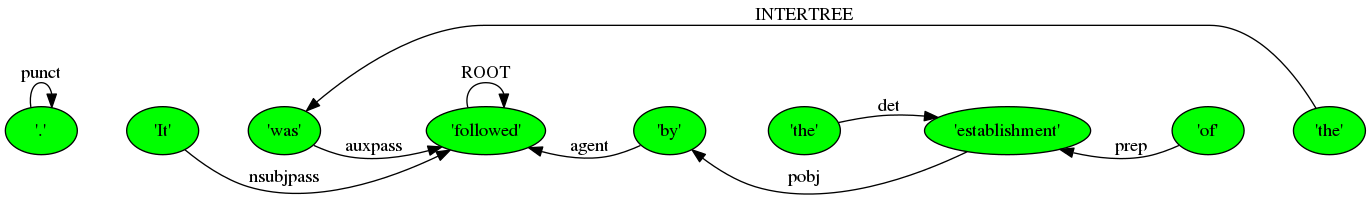

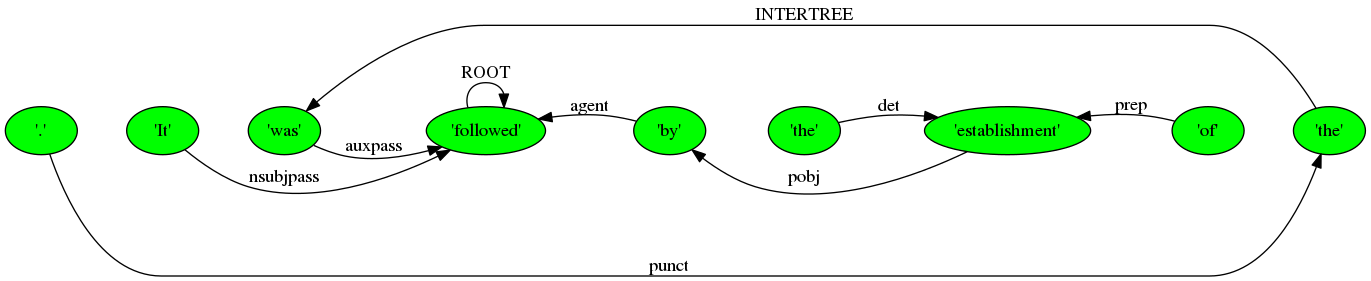

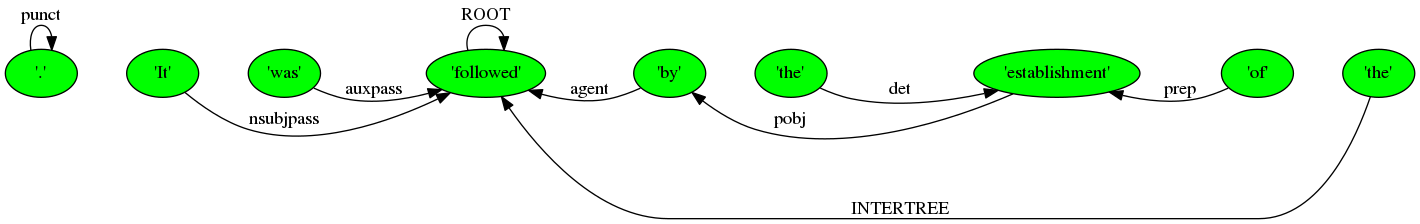

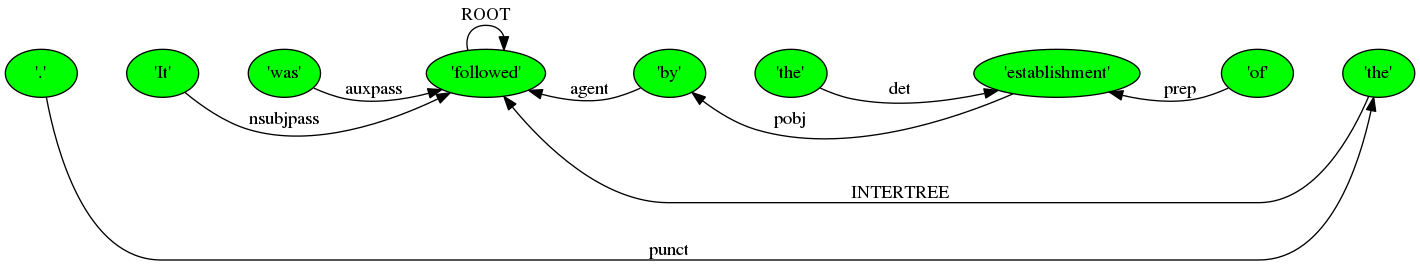

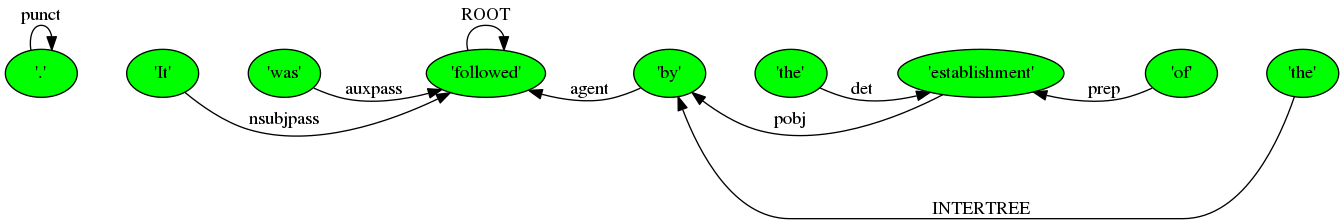

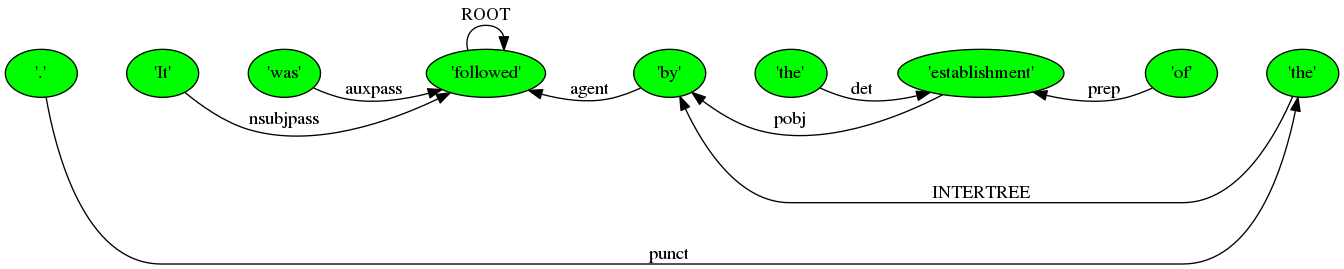

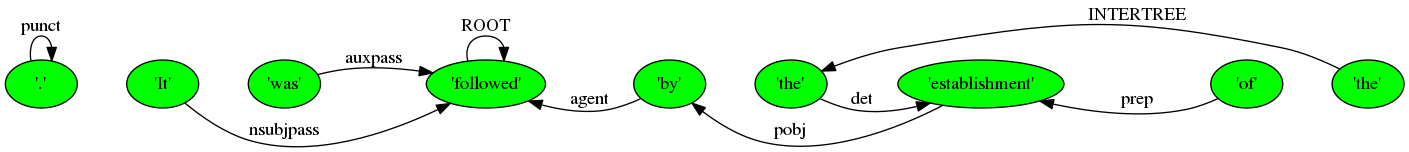

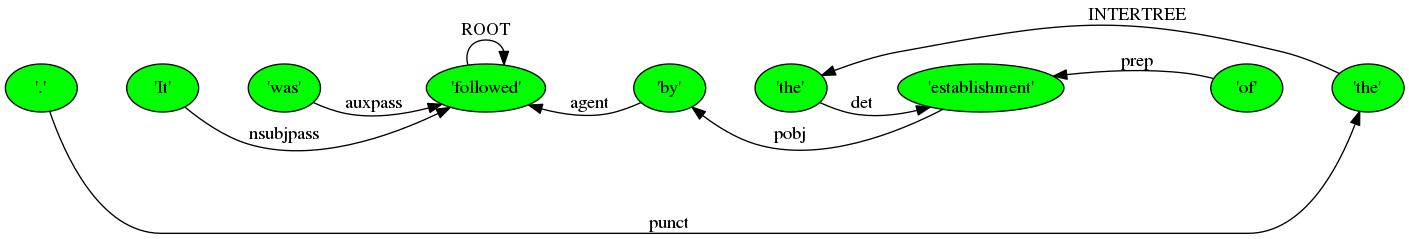

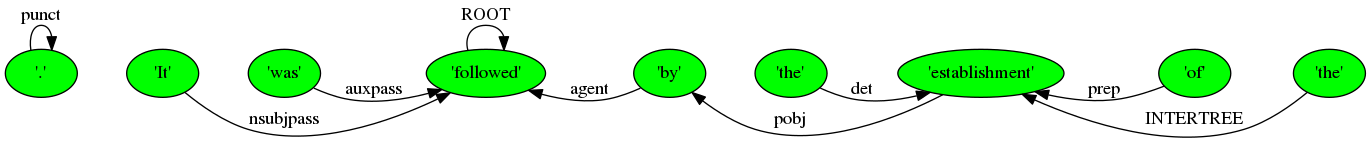

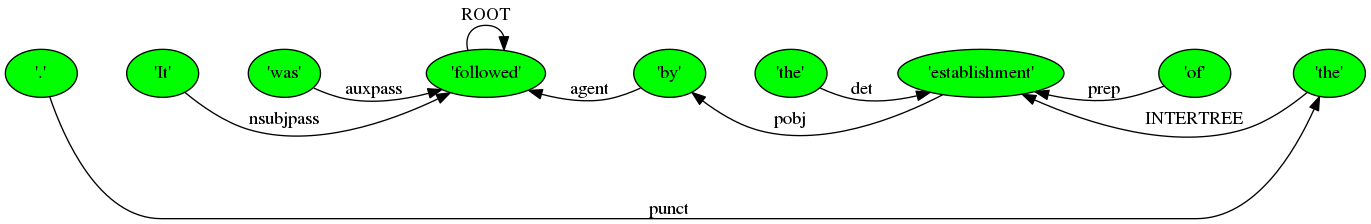

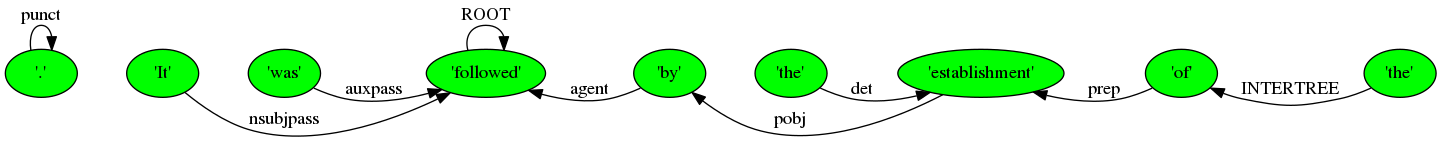

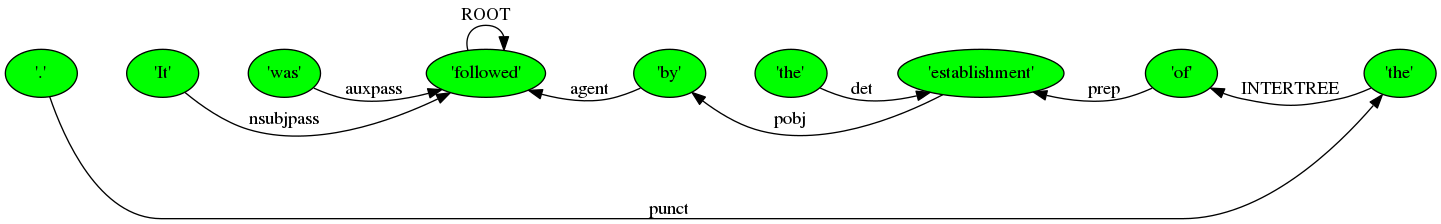

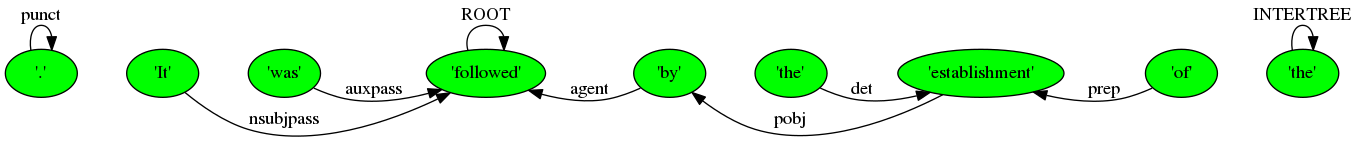

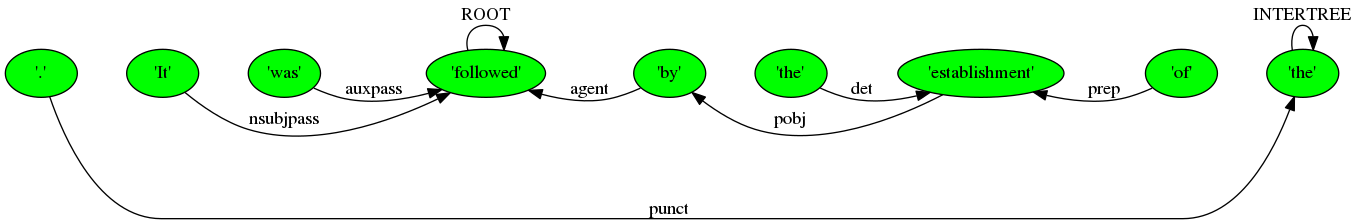

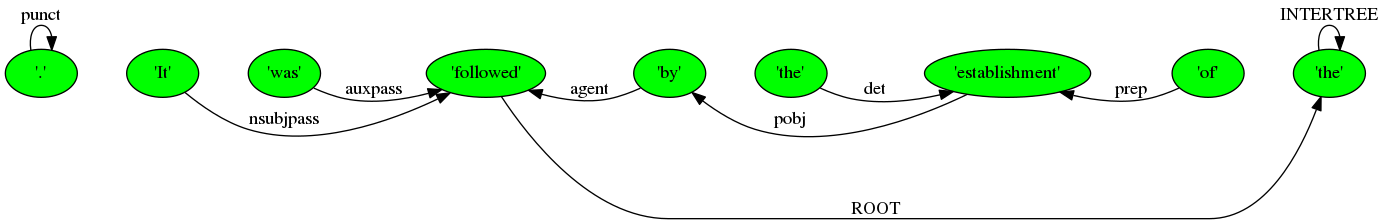

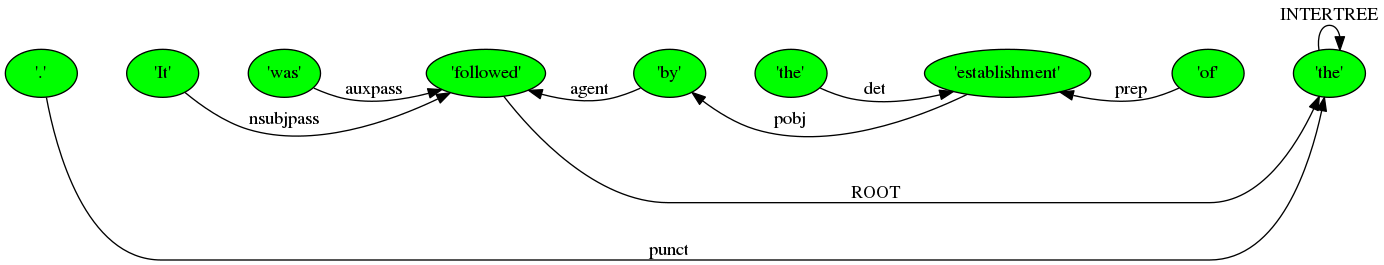

In [6]:
# create possible graphs (forests) for "new" data point with index = 9 (token: 'between')
ind = 8
sliced_edges[ind] = 0
forests, correct_forrest_ind, roots_orig, roots_cut_pos = forest_candidates(sliced_parents, ind)
print('correct_forrest_ind:', correct_forrest_ind)
for i, (children, parent) in enumerate(forests):
    temp_parents = np.copy(sliced_parents)
    temp_parents[ind] = parent
    for child in children:
        temp_parents[child] = ind - child
    fn = 'forest_'+str(i)+'.png'
    visualize(fn, (sliced_data, sliced_types, temp_parents, sliced_edges),
              data_embedding_maps_human)
    img = Image(fn)
    display(img)

In [14]:
net = Net(data_vecs, len(edge_map_human), dim, slice_size, max_forest_count)
print('output size:', net.max_graph_count * net.edge_count)
optimizer = optim.Adagrad(net.get_parameters(), lr=0.01, lr_decay=0, weight_decay=0)    # default meta parameters

ind = 1

data = np.array(seq_data[0:(ind + 1)])
types = np.array(seq_types[0:(ind + 1)])
parents = subgraph(seq_parents, 0, (ind + 1))
edges = np.array(seq_edges[0:(ind + 1)])

graphs = np.array(graph_candidates(parents, ind))

outputs = net(data, types, graphs, edges)
outputs = outputs.unsqueeze(0)
print('outputs:\t', outputs)
outputs_soft = F.softmax(outputs)
print('softmax:\t', outputs_soft)
print('sum:\t', torch.sum(outputs))
print('sum_soft:\t', torch.sum(outputs_soft))

output size: 12400
outputs:	 Variable containing:
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 1x12400]

softmax:	 Variable containing:
1.00000e-05 *
 8.0645  8.0645  8.0645  ...   8.0645  8.0645  8.0645
[torch.FloatTensor of size 1x12400]

sum:	 Variable containing:
 0
[torch.FloatTensor of size 1]

sum_soft:	 Variable containing:
 1
[torch.FloatTensor of size 1]



12400
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


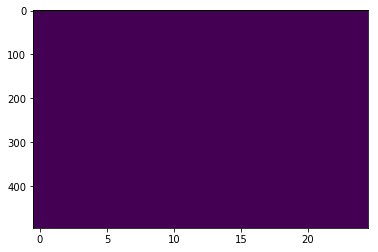

In [15]:
unfold_and_plot(outputs, net.edge_count)

12400
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


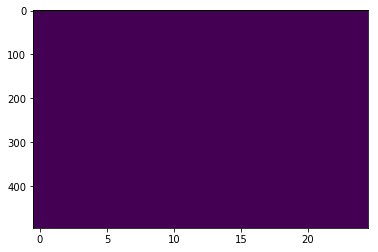

In [16]:
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
#optimizer = optim.Adagrad(net.get_parameters(), lr=0.01, lr_decay=0, weight_decay=0)    # default meta parameters

expected = Variable(torch.zeros(net.max_graph_count * net.edge_count).type(torch.FloatTensor))#, requires_grad=False)
expected[0] = 1

unfold_and_plot(expected, net.edge_count)

In [17]:
#loss = F.cross_entropy(outputs_soft, expected)
loss = (outputs_soft - expected).pow(2).sum()
loss

Variable containing:
 0.9999
[torch.FloatTensor of size 1]

In [18]:
optimizer.zero_grad()

In [19]:
loss.backward()

RuntimeError: matrices expected, got 1D, 2D tensors at /data/users/soumith/miniconda2/conda-bld/pytorch-0.1.7_1485404111338/work/torch/lib/TH/generic/THTensorMath.c:857